# Sharpen with bilinear and sharp u net

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [9]:
from tensorflow.keras.layers import Input, Dense, ReLU, Add, Conv1D, BatchNormalization, LayerNormalization, Layer, Flatten, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, DepthwiseConv2D
from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from tensorflow.image import resize


### Set up for up and down scaling

In [2]:
def get_kernel():
    """
    See https://setosa.io/ev/image-kernels/
    """

    k1 = np.array([[0.0625, 0.125, 0.0625],
                   [0.125,  0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    
    k3 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    
    return k1, k2, k3


def build_sharp_blocks(layer):
    """
    Sharp Blocks
    """
    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w

In [21]:
def SharpUNet(inputs, num_classes):
    "Unet with sharp Blocks in skip connections"

    # Kernel size for sharp blocks
    kernel_size = 3

    #inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_sharp_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_sharp_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_sharp_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_sharp_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    #conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)
    
    #model = Model(inputs=[inputs], outputs=[conv10])    
    
    return conv9


In [4]:
def rationalConv(x, filters=16, kernel_size=(3,3), padding="same", start=7, end=3):
    """
    Where ordinary convolutions down-scale by an integer stride, 
    the rational version up-samples and down-scales an integer stride to 
    reach a desired rational upscaling.

    Example: 7 -> 3 => 7 * bilinear(9/7) = 9, 9 / conv(3) = 3
    """
    size = x.shape
    stride = np.ceil(start/end).astype(int)
    scaling = (end*stride)/start
    
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    if stride > 1:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    return x

def rationalConvTransposed(x, filters=16, kernel_size=(3,3), padding="same", start=3, end=7):
    """
    Where ordinary transposed convolutions up-scale by an integer stride, 
    the rational version up-scales an integer stride and down-samples to 
    reach a desired rational upscaling.
    
    Example: 3 -> 7 => 3 * convTr(3) = 9, 9 * bilinear(7/9) = 7
    """
    size = x.shape
    stride = np.ceil(end/start).astype(int)
    scaling = end/start
    
    if stride > 1:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    return x

"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    #outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    return c9
    #model = Model(inputs=[input_img], outputs=[outputs])
    #return 



In [22]:

input_img = Input(shape=(55,55,3))

x = rationalConvTransposed(input_img, filters=3,end=7, start=3)
x = Conv2D(3, kernel_size=3, padding="same", activation='linear')(x)
x = SharpUNet(x, num_classes=1)

x = Conv2D(3, kernel_size=3, padding="same", activation='linear')(x)

model = Model(inputs = [input_img], outputs = [x])
#model.compile(optimizer='adam',
#              loss='mse')
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 55, 55, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_transpose_26 (Conv2DTran (None, 165, 165, 3)  84          input_22[0][0]                   
__________________________________________________________________________________________________
tf.image.resize_4 (TFOpLambda)  (None, 128, 128, 3)  0           conv2d_transpose_26[0][0]        
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 128, 128, 3)  84          tf.image.resize_4[0][0]          
____________________________________________________________________________________________

## Load data - show data

In [24]:
X = np.load("sharpen/X_data.npy")
y = np.load("sharpen/y_data.npy")

X = X[:,:,:,:]
y = y[:,:,:,:]

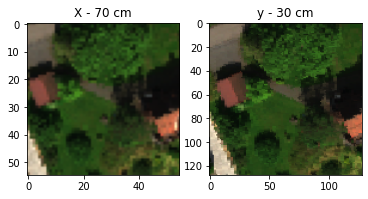

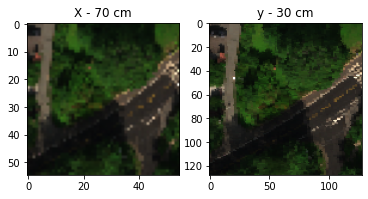

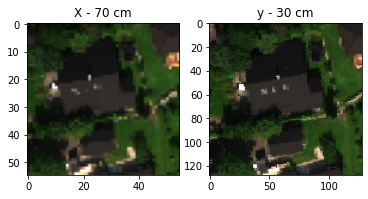

In [25]:
indx = np.random.randint(0,high=X.shape[0],size=3)
for i in range(3):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
  ax1.imshow(X[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y[indx[i]]); ax2.set_title("y - 30 cm")
  plt.show()

In [26]:
y.shape

(50, 128, 128, 3)

In [60]:
h = model.fit(X,y,
              batch_size=10,
              epochs=550)

Epoch 1/550
5/5 [==============================] - 3s 44ms/step - loss: 0.4430
Epoch 2/550
5/5 [==============================] - 0s 37ms/step - loss: 0.2043
Epoch 3/550
5/5 [==============================] - 0s 37ms/step - loss: 0.1252
Epoch 4/550
5/5 [==============================] - 0s 37ms/step - loss: 0.0776
Epoch 5/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0516
Epoch 6/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0394
Epoch 7/550
5/5 [==============================] - 0s 37ms/step - loss: 0.0325
Epoch 8/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0278
Epoch 9/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0245
Epoch 10/550
5/5 [==============================] - 0s 37ms/step - loss: 0.0225
Epoch 11/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0207
Epoch 12/550
5/5 [==============================] - 0s 38ms/step - loss: 0.0195
Epoch 13/550
5/5 [==============================]

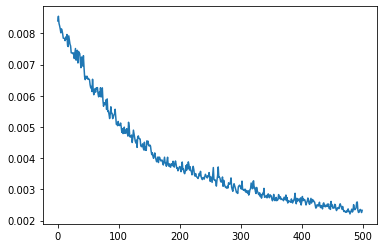

In [34]:
plt.plot(h.history['loss'][50:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


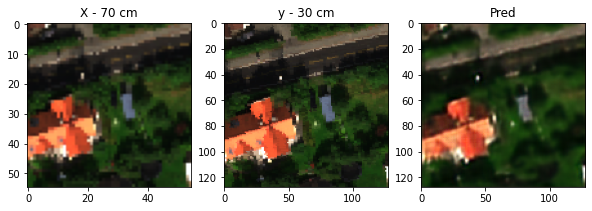

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


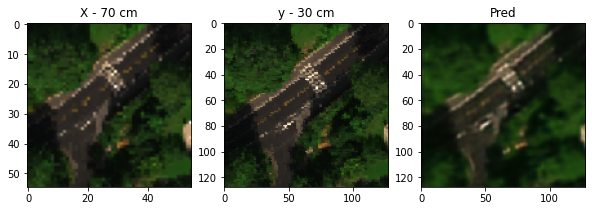

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


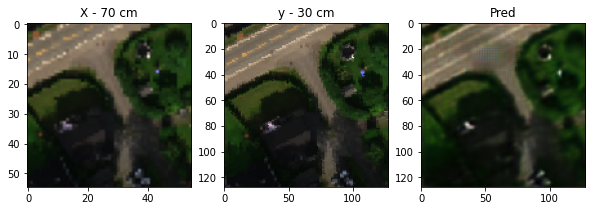

In [61]:
indx = np.random.randint(0,high=X.shape[0],size=3)
for i in range(3):
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
  pred = model.predict(X[indx[i]:indx[i]+1])[0]
  ax1.imshow(X[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y[indx[i]]); ax2.set_title("y - 30 cm")
  ax3.imshow(pred[:,:,:]); ax3.set_title("Pred")
  plt.show()


In [62]:
sample_model = Model(inputs=model.input, outputs=[model.layers[2].output])

In [63]:
sample_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 55, 55, 3)]       0         
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 165, 165, 3)      84        
 Transpose)                                                      
                                                                 
 tf.image.resize_5 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


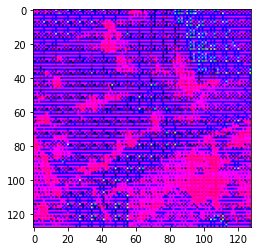

In [67]:
plt.imshow(sample_model.predict(X[4:5])[0]*100)

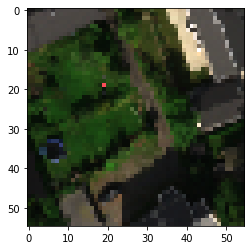

In [68]:
plt.imshow(X[4:5][0])